# Quantile Regression
_A simple method to estimate uncertainty in Machine Learning_

<a href="https://github.com/cgarciae/quantile-regression" target="_parent">
    <img src="https://img.shields.io/badge/R-Open%20Repo-blue"/>
</a>
<a href="https://hackmd.io/@cgarciae/quantile-regression" target="_parent">
    <img src="https://img.shields.io/badge/B-Open%20Blog-blue"/>
</a>
<a href="https://hackmd.io/@cgarciae/quantile-regression-presentation#/" target="_parent">
    <img src="https://img.shields.io/badge/S-Open%20Slides-blue"/>
</a>
<a href="https://colab.research.google.com/github/cgarciae/quantile-regression/blob/master/main.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>



## Motivation
When trying to predict and output, it is sometimes helpful to get a confidence score
or, similarly, a range of values around this expected value in which the actual value might be found. 
Practical examples include estimating upper and lower bound when predicting a time of arrival (ETA) or a 
stock price since you care about an expected value and the best case and worst-case scenarios when trying to minimize risk.

While most Machine Learning techniques do not provide a natural way of doing this, 
in this article, we will be exploring **Quantile Regression** as a means of doing so; 
and this technique will allow us to learn some critical statistical properties 
of our data: the quantiles.

<details>
<summary markdown="span">Install Dependencies</summary>

In [1]:
# uncomment to install dependencies
# ! curl -Ls https://raw.githubusercontent.com/Davidnet/quantile-regression/master/requirements.txt > requirements.txt
# ! pip install -qr requirements.txt

</details>

To begin our journey into quantile regression, we will first get a hold on some data:

<details>
<summary markdown="span">Show Code</summary>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.facecolor"] = "white"
np.random.seed(69)


def create_data(multimodal: bool):
    x = np.random.uniform(0.3, 10, 1000)
    y = np.log(x) + np.random.exponential(0.1 + x / 20.0)

    if multimodal:
        x = np.concatenate([x, np.random.uniform(5, 10, 500)])
        y = np.concatenate([y, np.random.normal(6.0, 0.3, 500)])

    return x[..., None], y[..., None]


multimodal: bool = False

x, y = create_data(multimodal)

fig = plt.figure()
plt.scatter(x[..., 0], y[..., 0], s=20, facecolors="none", edgecolors="k")
plt.close()

</details>

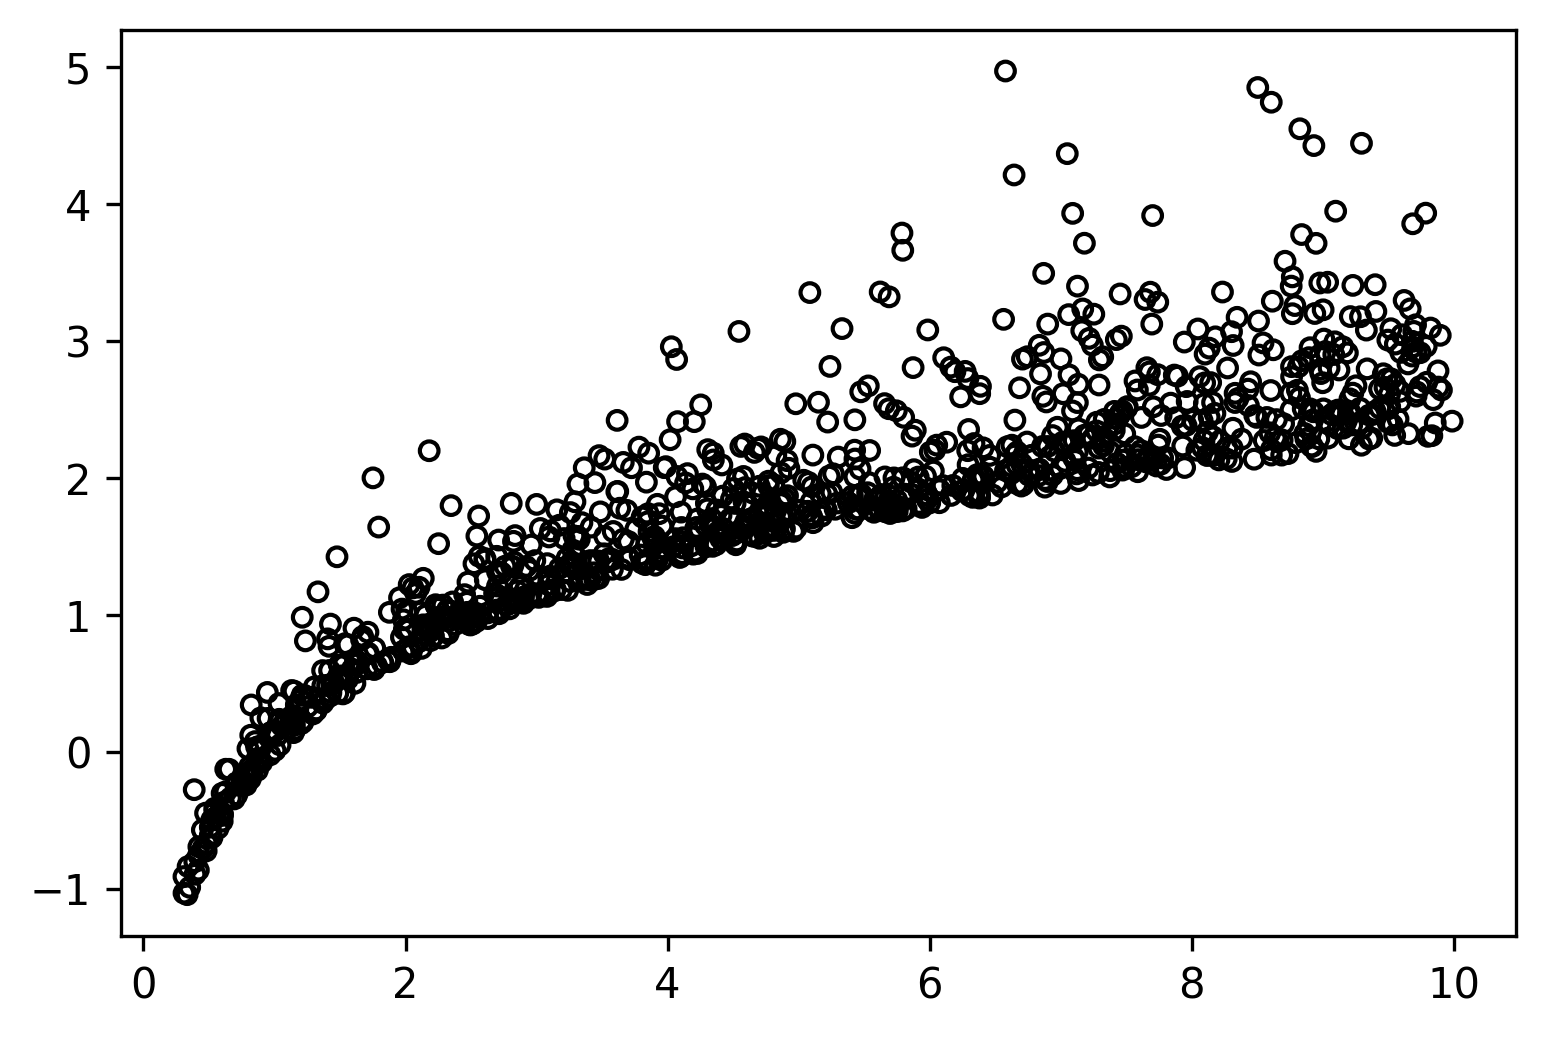

In [3]:
fig

Here we have a simple 2D dataset; however, notice that `y` has some very peculiar statistical properties:

1. The data does not have the property of being normally distributed. The data is exponentially distributed.
2. The previous also means its noise is not symmetric.
3. Its variance is not constant. It increases as x increases.

When making predictions for this kind of data, we might be very interested in knowing what range of values our data revolves around such that we can judge if a specific outcome is expected or not, what are the best and worst-case scenarios, and so on.

## Quantile Loss
The only thing special about quantile regression is its loss function. Instead of the usual MAE or MSE losses for quantile regression, we use the following function:

$$
\begin{aligned}
    E &= y - f(x) \\
    L_q &= \begin{cases}
        q  E,     &    E \gt 0  \\
        (1 - q) (-E), &    E \lt 0
    \end{cases}
\end{aligned}
$$

Here $E$ is the error term, and $L_q$ is the loss function for the quantile $q$. So what do we mean by this? Concretely it means that $L_q$ will bias $f(x)$ to output the value of the $q$'th quantile instead of the usual mean or median statistic. The big question is: how does it do it?

First lets notice that this formula can be rewritten as follows:

$$
\begin{aligned}
    E &= y - f(x) \\
    L_q &= \max \begin{cases}
        q  E   \\
        (q - 1) E
    \end{cases}
\end{aligned}
$$

Using $\max$ instead of a conditional statement will make it more straightforward to implement on tensor/array libraries. We will do this next in jax.

In [4]:
import jax
import jax.numpy as jnp


def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return jnp.maximum(q * e, (q - 1.0) * e)

## Loss Landscape
Now that we have this function let us explore the error landscape for a particular set of predictions. Here we will generate values for `y_true` in the range $[10, 20]$, and for a particular value of $q$ (0.8 by default), we will compute the total error you would get for each value `y_pred` could take. Ideally, we want to find the value of `y_pred` where the error is the smallest.

<details>
<summary markdown="span">Show code</summary>

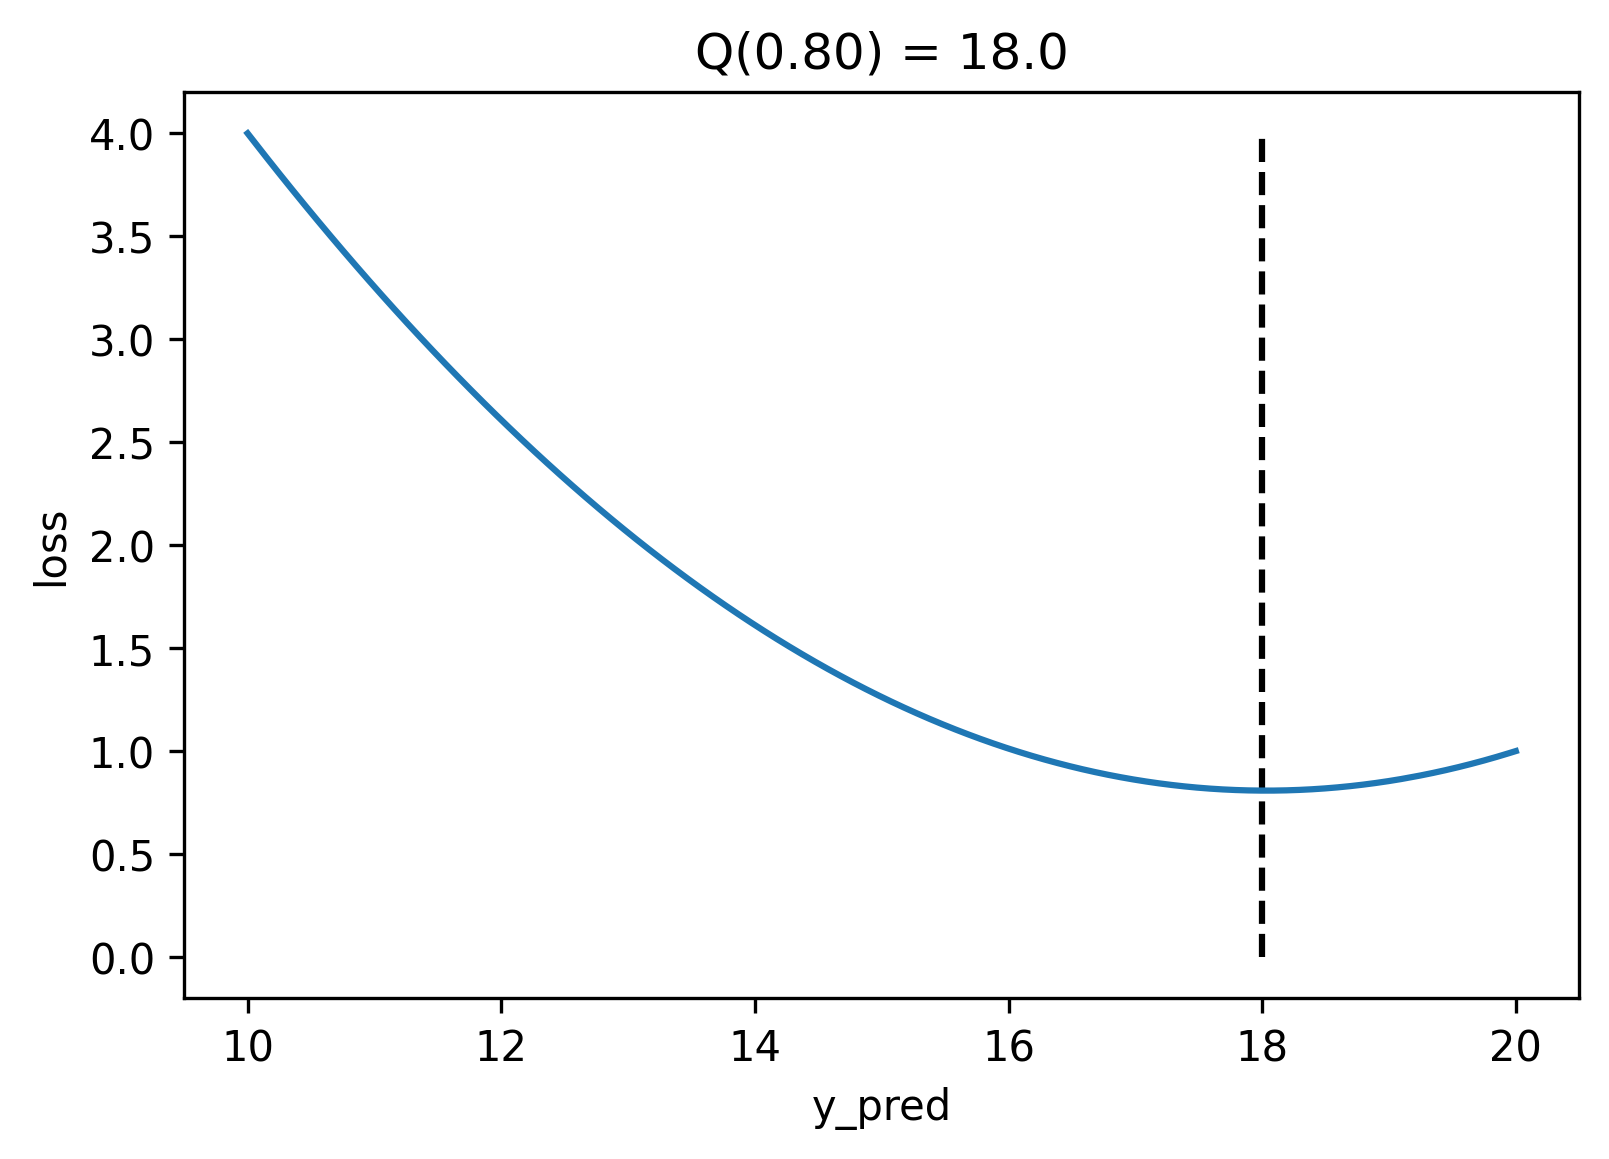

In [5]:
def calculate_error(q):
    y_true = np.linspace(10, 20, 100)
    y_pred = np.linspace(10, 20, 200)

    loss = jax.vmap(quantile_loss, in_axes=(None, None, 0))(q, y_true, y_pred)
    loss = loss.mean(axis=1)

    return y_true, y_pred, loss


q = 0.8
y_true, y_pred, loss = calculate_error(q)
q_true = np.quantile(y_true, q)


plt.plot(y_pred, loss)
plt.vlines(q_true, 0, loss.max(), linestyles="dashed", colors="k")
plt.gca().set_xlabel("y_pred")
plt.gca().set_ylabel("loss")
plt.title(f"Q({q:.2f}) = {q_true:.1f}")
plt.show()

</details>

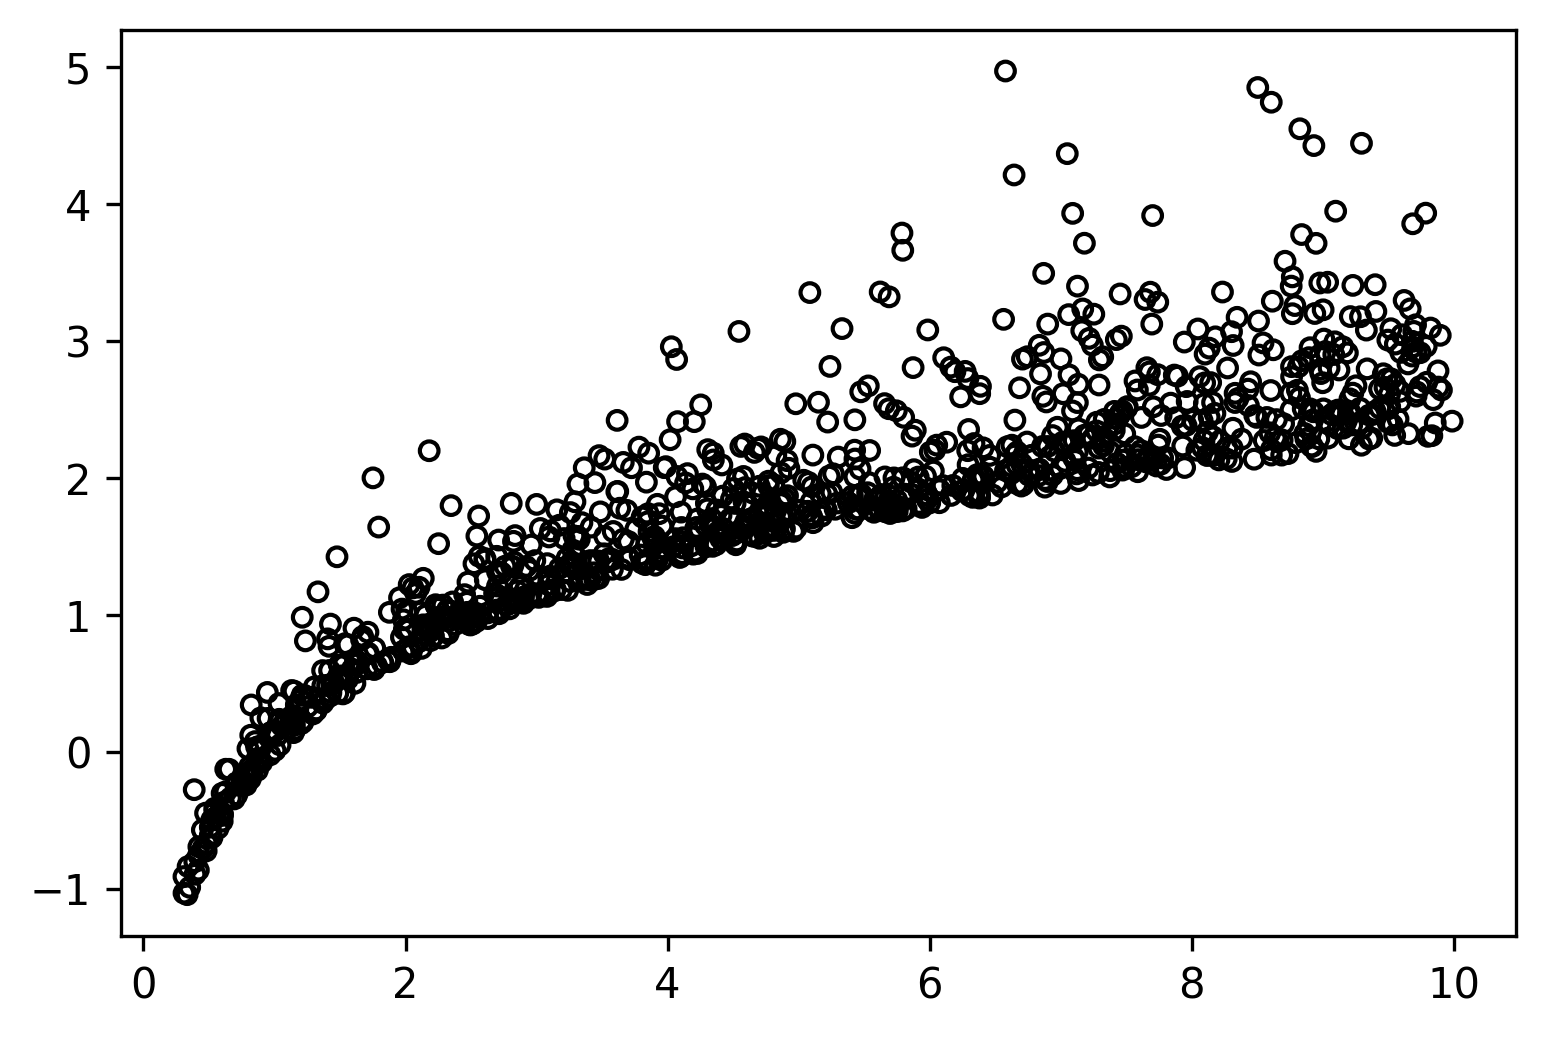

In [6]:
fig

If we plot the error, the quantile loss's minimum value is strictly at the value of the $q$th quantile. It achieves this because the quantile loss is not symmetrical; for quantiles above `0.5` it penalizes positive  errors stronger than negative errors, and the opposite is true for quantiles below `0.5`. In particular, quantile `0.5` is the median, and its formula is equivalent to the MAE.

## Deep Quantile Regression

Generally, we would need to create to create a model per quantile. However, if we use a neural network, we can output the predictions for all the quantiles simultaneously. Here will use `elegy` to create a neural network with two hidden layers with `relu` activations and linear layers with `n_quantiles` output units.

In [7]:
import elegy


class QuantileRegression(elegy.Module):
    def __init__(self, n_quantiles: int):
        super().__init__()
        self.n_quantiles = n_quantiles

    def call(self, x):
        x = elegy.nn.Linear(128)(x)
        x = jax.nn.relu(x)
        x = elegy.nn.Linear(64)(x)
        x = jax.nn.relu(x)
        x = elegy.nn.Linear(self.n_quantiles)(x)

        return x

Now we will adequately define a `QuantileLoss` class that is parameterized by
a set of user-defined `quantiles`.

<details>
<summary markdown="span">Show code</summary>

In [8]:
class QuantileLoss(elegy.Loss):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = np.array(quantiles)

    def call(self, y_true, y_pred):
        loss = jax.vmap(quantile_loss, in_axes=(0, None, -1), out_axes=1)(
            self.quantiles, y_true[:, 0], y_pred
        )
        return jnp.sum(loss, axis=-1)

</details>

Notice that we use the same `quantile_loss` that we created previously, along with some `jax.vmap` magic to properly vectorize the function. Finally, we will create a simple function that creates and trains our model for a set of quantiles using `elegy`.

<details>
<summary markdown="span">Show code</summary>

In [9]:
import optax


def train_model(quantiles, epochs: int, lr: float, eager: bool):
    model = elegy.Model(
        QuantileRegression(n_quantiles=len(quantiles)),
        loss=QuantileLoss(quantiles),
        optimizer=optax.adamw(lr),
        run_eagerly=eager,
    )

    model.fit(x, y, epochs=epochs, batch_size=64, verbose=0)

    return model


if not multimodal:
    quantiles = (0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95)
else:
    quantiles = np.linspace(0.05, 0.95, 9)

model = train_model(quantiles=quantiles, epochs=3001, lr=1e-4, eager=False)

</details>

In [10]:
model.summary(x)

Now that we have a model let us generate some test data that spans the entire domain and compute the predicted quantiles.

<details>
<summary markdown="span">Show code</summary>

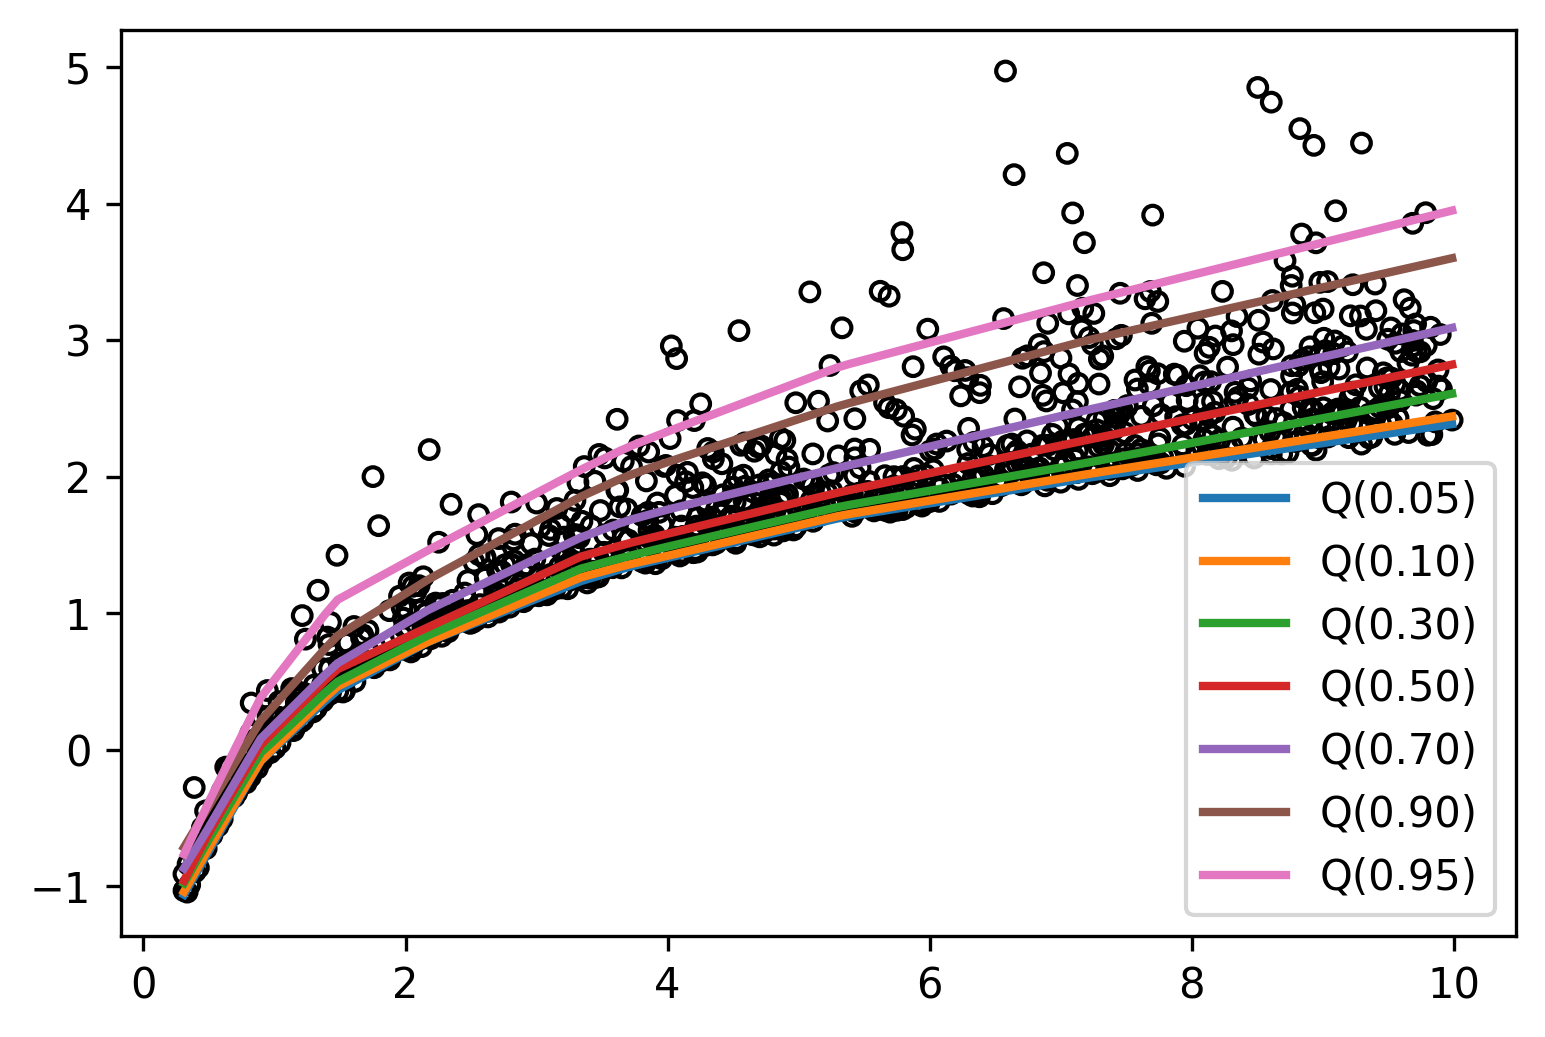

In [11]:
x_test = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(x_test[..., None])

plt.scatter(x, y, s=20, facecolors="none", edgecolors="k")

for i, q_values in enumerate(np.split(y_pred, len(quantiles), axis=-1)):
    plt.plot(x_test, q_values[:, 0], linewidth=2, label=f"Q({quantiles[i]:.2f})")

plt.legend()
plt.show()

</details>

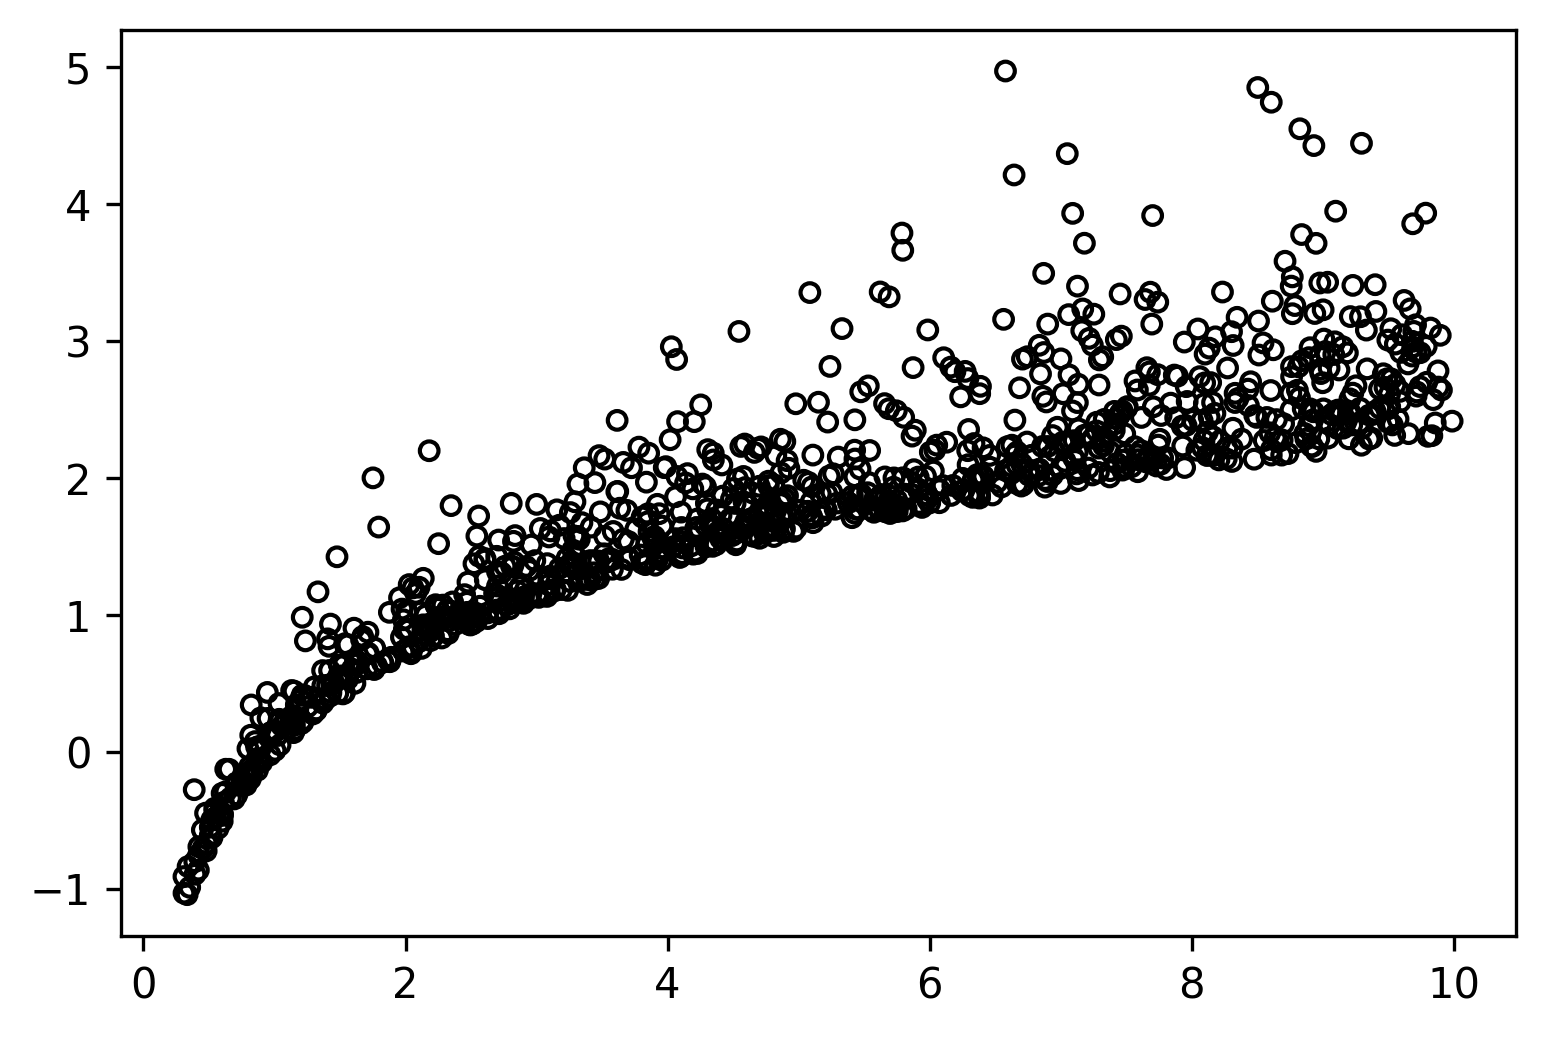

In [12]:
fig

Amazing! Notice how the first few quantiles are tightly packed together while the last ones spread out, capturing the behavior of the exponential distribution. We can also visualize the region between the highest and lowest quantiles, and this gives us some bounds on our predictions.

<details>
<summary markdown="span">Show code</summary>

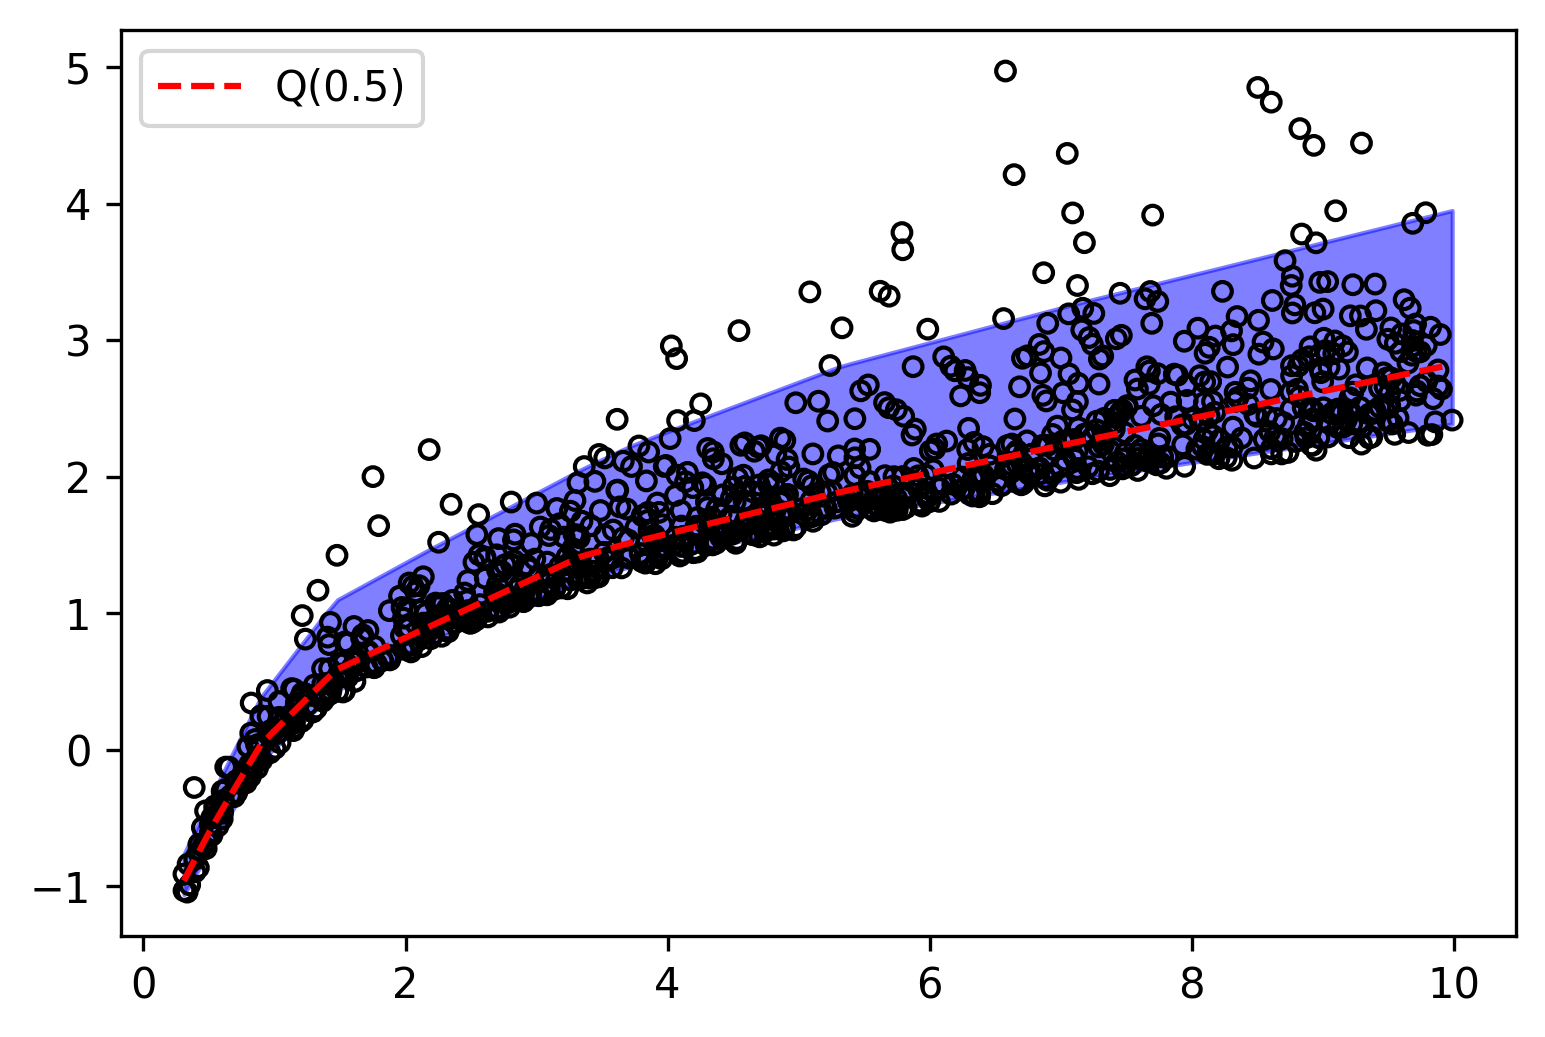

In [13]:
median_idx = np.where(np.isclose(quantiles, 0.5))[0]

plt.fill_between(x_test, y_pred[:, -1], y_pred[:, 0], alpha=0.5, color="b")
plt.scatter(x, y, s=20, facecolors="none", edgecolors="k")
plt.plot(
    x_test,
    y_pred[:, median_idx],
    color="r",
    linestyle="dashed",
    label="Q(0.5)",
)
plt.legend()
plt.show()

</details>

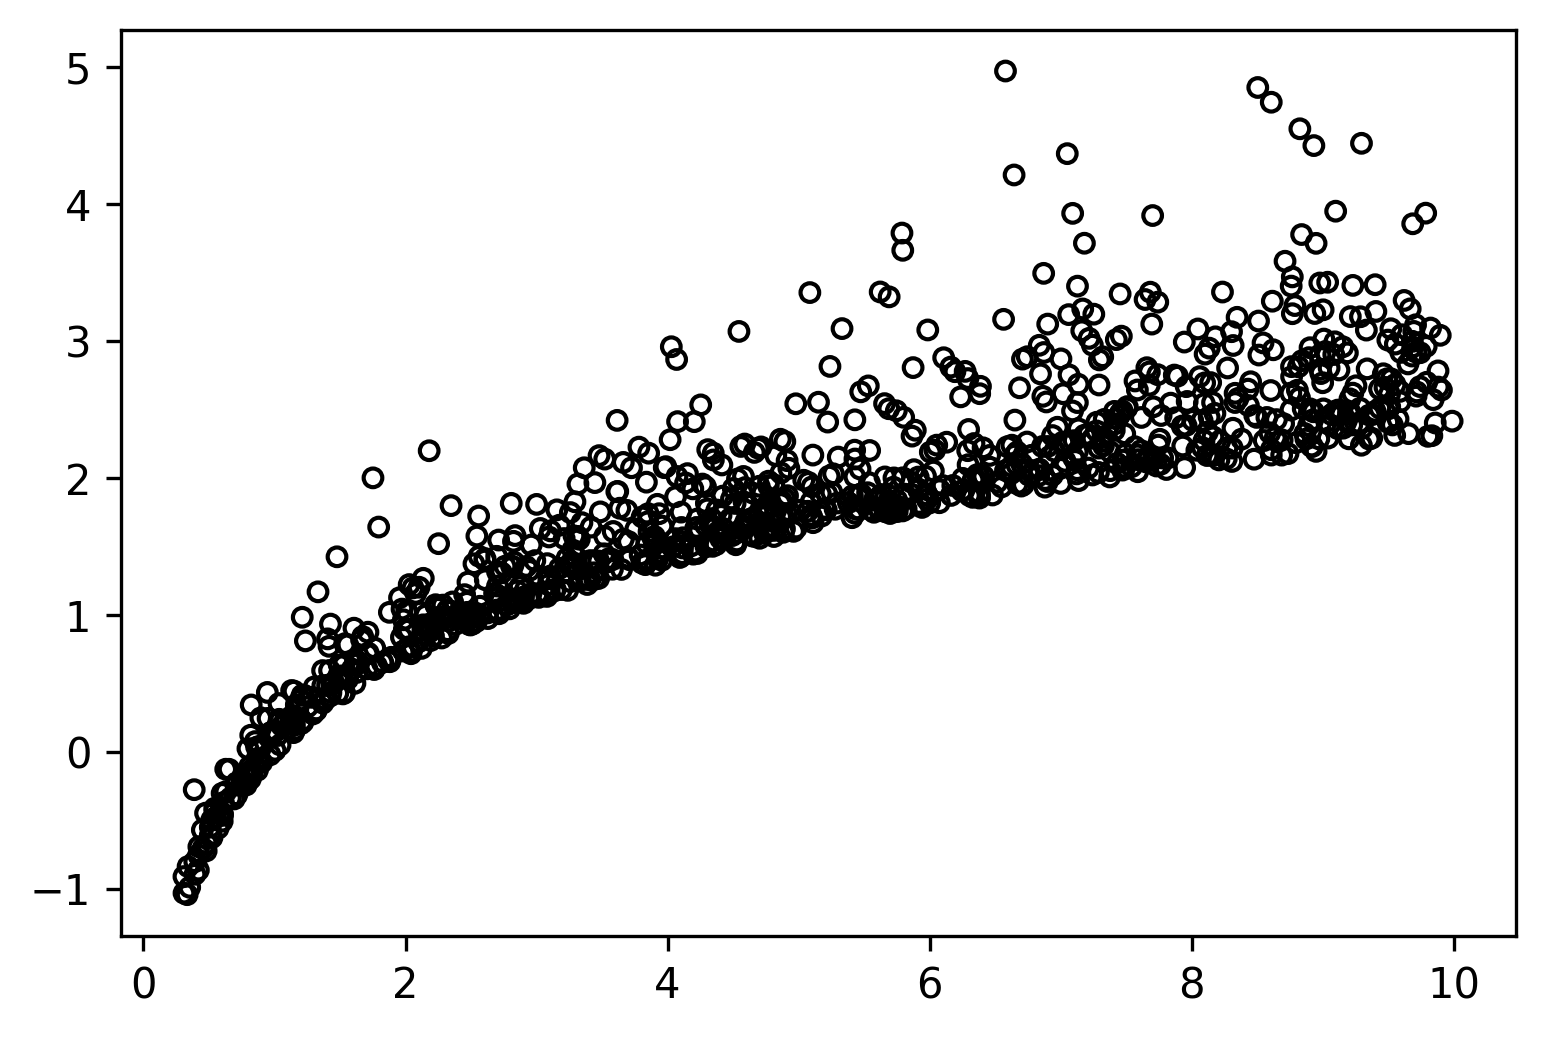

In [14]:
fig

On the other hand, having multiple quantile values allows us to estimate the density of the data. Since the difference between two adjacent quantiles represent the probability that a point lies between them, we can construct a piecewise function that approximates the density of the data.

<details>
<summary markdown="span">Show code</summary>

In [15]:
def get_pdf(quantiles, q_values):
    densities = []

    for i in range(len(quantiles) - 1):
        area = quantiles[i + 1] - quantiles[i]
        b = q_values[i + 1] - q_values[i]
        a = area / b

        densities.append(a)

    return densities


def piecewise(xs):
    return [xs[i + j] for i in range(len(xs) - 1) for j in range(2)]


def doubled(xs):
    return [np.clip(xs[i], 0, 3) for i in range(len(xs)) for _ in range(2)]

</details>

For a given `x`, we can compute the quantile values and then use these to compute the conditional piecewise density function of `y` given `x`.

<details>
<summary markdown="span">Show code</summary>

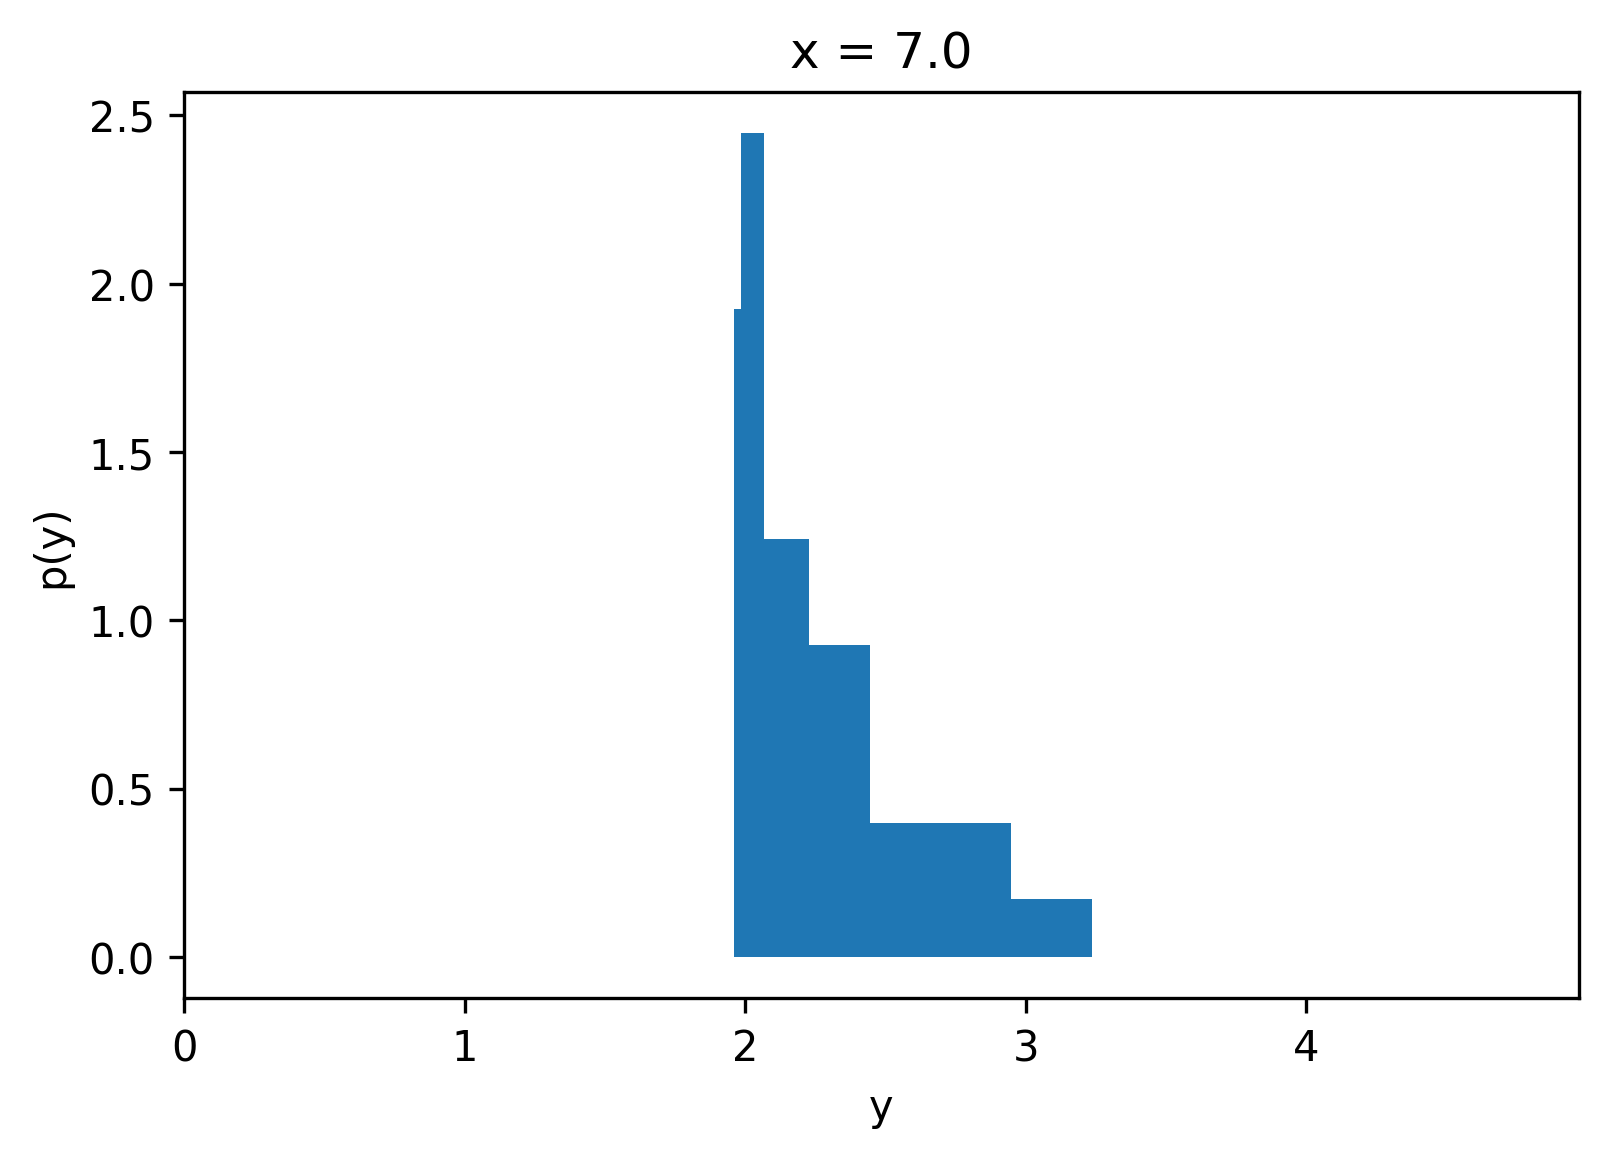

In [16]:
xi = 7.0

q_values = model.predict(np.array([[xi]]))[0].tolist()

densities = get_pdf(quantiles, q_values)

plt.title(f"x = {xi}")
plt.fill_between(piecewise(q_values), 0, doubled(densities))
# plt.fill_between(q_values, 0, densities + [0])
# plt.plot(q_values, densities + [0], color="k")
plt.xlim(0, y.max())
plt.gca().set_xlabel("y")
plt.gca().set_ylabel("p(y)")
plt.show()

</details>

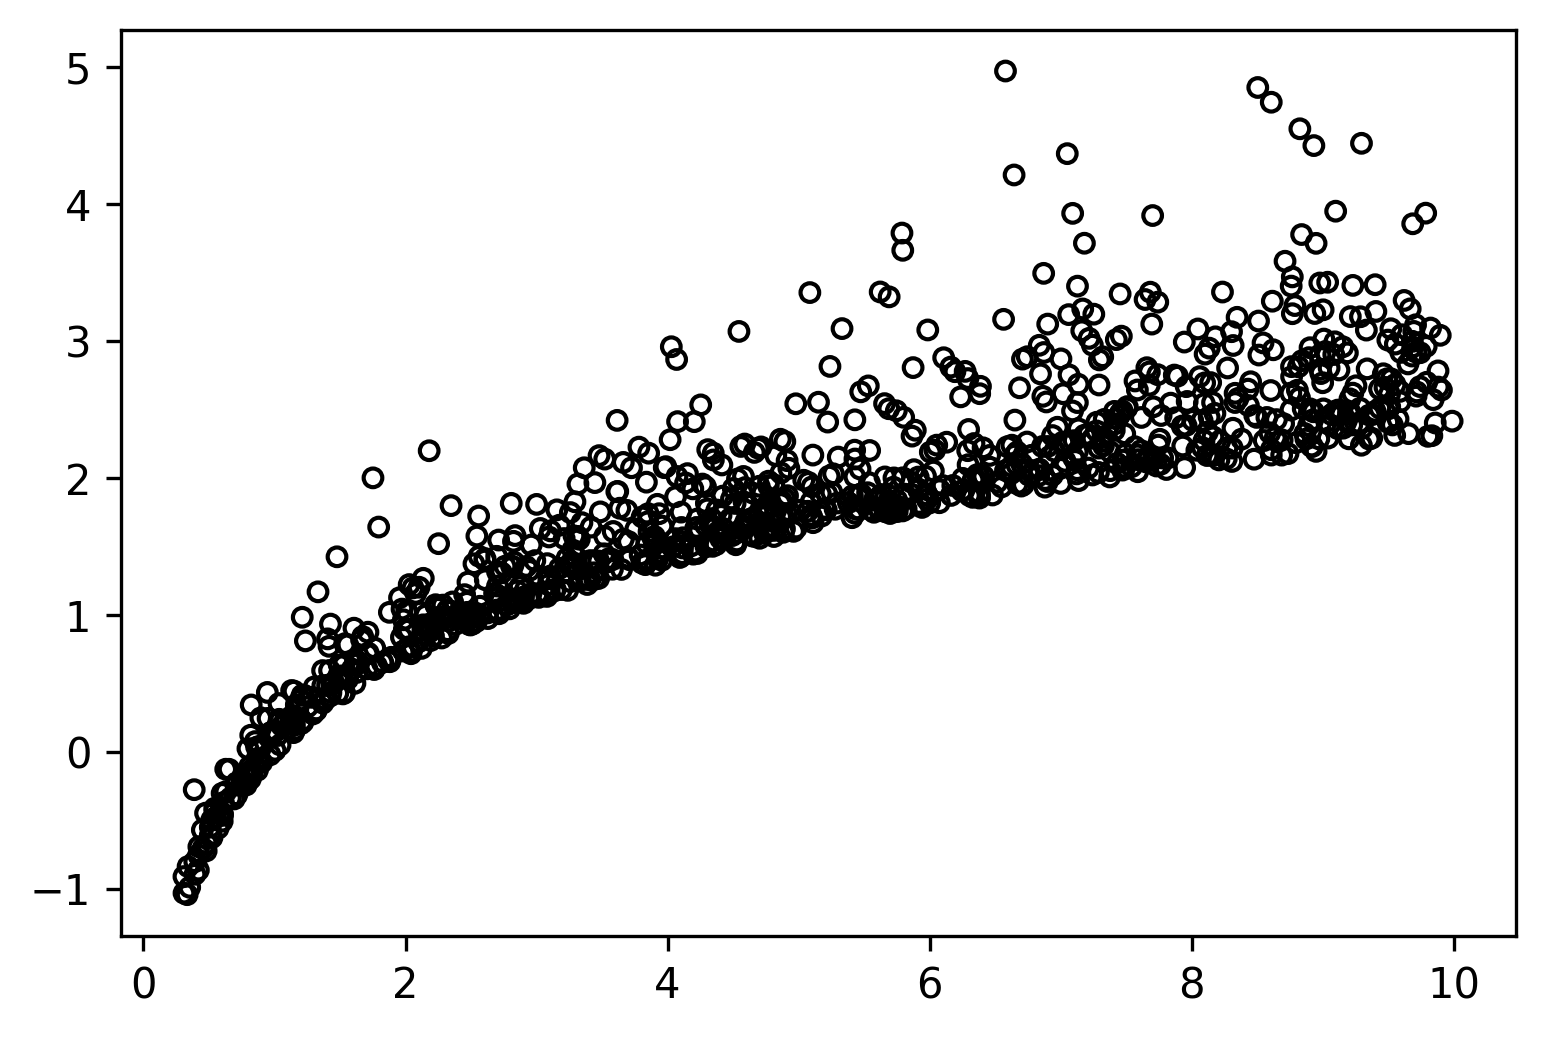

In [17]:
fig

One of the exciting properties of Quantile Regression is that we did not need to know a priori the output distribution, and training is easy compared to other methods.

## Recap
* Quantile Regression is a simple and effective method for learning some statistics
about the output distribution.
* It is advantageous to establish bounds on the predictions of a model when risk management is desired.
* The Quantile Loss function is simple and easy to implement.
* Quantile Regression can be efficiently implemented using Neural Networks since a single model can predict all the quantiles.
* The quantiles can be used to estimate the conditional density of the data.

## Next Steps
* Try running this notebook with `multimodal = True`.
* Take a look at Mixture Density Networks.
* Learn more about [jax](https://github.com/google/jax) and [elegy](https://github.com/poets-ai/elegy).

## Acknowledgments
Many thanks to [David Cardozo](https://github.com/davidnet) for his proofreading and getting the notebook to run in colab.